# Fig4c - Kymograph Generation from Multi-Channel TIFF Time Series

## Overview
This notebook processes three-channel time-lapse microscopy data stored as multi-frame TIFF stacks, generates spatial–temporal kymographs for each channel, and exports both raw and normalized projection data.  
The workflow includes:
- Loading TIFF image sequences for three channels (e.g., different fluorophores)
- Computing intensity projections along the cell axis
- Aligning projections across frames
- Normalizing intensity values
- Creating transparent colormap kymographs (SVG format)
- Saving raw and normalized data to CSV for further analysis

---

## Input Requirements
- **Three multi-frame TIFF stacks** representing different imaging channels (C1, C2, C3).
- **File paths** to the TIFF stacks.
- **Python environment** with required packages installed:  
  `numpy`, `matplotlib`, `PIL` (`Pillow`), `pandas`, `IPython`.

---

## Outputs
1. **Kymographs** (`.svg`) for each channel — transparent background, labeled with “Pole 1 / Equator / Pole 2”.
2. **CSV file** containing:
   - Raw projection intensity values
   - Normalized projection intensity values
   - Position labels, channel labels, and time points
3. Files are saved in the specified output directory.

---

## How to Run

### 1. Set paths:
```python
tiff_path_c1 = "path/to/channel1_stack.tif"  # Path to C1 TIFF file
tiff_path_c2 = "path/to/channel2_stack.tif"  # Path to C2 TIFF file
tiff_path_c3 = "path/to/channel3_stack.tif"  # Path to C3 TIFF file
output_dir   = "path/to/output_directory"    # Folder for results
```

### 2. Configure analysis parameters:
```python
time_interval_seconds = 20  # Time interval between frames in seconds
```

### 3. Run all cells in order:
   - Ensure dependencies are installed.
   - Execute each cell from top to bottom without skipping.

### 4. Check output files in the specified directory.
   - .svg kymographs will be in output_dir
   - .csv file will be in output_dir containing raw & normalized data
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import os
import pandas as pd
from pathlib import Path

## Configuration

In [2]:
# Time interval between frames (seconds)
time_interval_seconds = 20

# Input file paths
tiff_path_c1 = Path("02_Fig4B_straightener_output/c1_membrane_straight_stack.tif")
tiff_path_c2 = Path("02_Fig4B_straightener_output/c2_MinC_straight_stack.tif")
tiff_path_c3 = Path("02_Fig4B_straightener_output/c3_straight_stack.tif")

# Output directory
output_dir = Path("04_Fig4C_plot_output")

## Color Scheme Definitions

In [3]:
def create_transparent_cmap(base_cmap_name):
    """Create custom transparent gradient colormap"""
    base_cmap = plt.get_cmap(base_cmap_name)
    colors = base_cmap(np.linspace(0, 1, 256))
    colors[:, -1] = np.linspace(0, 1, 256)  # Adjust alpha channel
    return LinearSegmentedColormap.from_list(f"{base_cmap_name}_Transparent", colors)

# Create transparent colormaps
Greens_Transparent = create_transparent_cmap("Greens")
Reds_Transparent = create_transparent_cmap("Reds")
Purples_Transparent = create_transparent_cmap("Purples")

## Core Functions

In [4]:
def load_tiff_frames(tiff_path):
    """Load TIFF image sequence frames"""
    img = Image.open(tiff_path)
    frames = []
    try:
        while True:
            frames.append(np.array(img.convert('L')))
            img.seek(img.tell() + 1)
    except EOFError:
        pass
    return frames

def calculate_projections(image, axis=0):
    """Calculate intensity projection along specified axis"""
    return np.sum(image, axis=axis)

def normalize_data_0_to_max(data):
    """0-to-max normalization: 0 remains 0, maximum becomes 1"""
    max_val = np.max(data)
    if max_val > 0:
        return data / max_val
    return data

def align_projections_to_center(projections_list):
    """Center-align projections of different lengths by padding with zeros"""
    max_width = max(len(proj) for proj in projections_list)
    
    aligned_projections = []
    for proj in projections_list:
        current_width = len(proj)
        if current_width == max_width:
            aligned_projections.append(proj)
        else:
            padding_total = max_width - current_width
            padding_left = padding_total // 2
            padding_right = padding_total - padding_left
            
            aligned_proj = np.pad(proj, (padding_left, padding_right), 
                                mode='constant', constant_values=0)
            aligned_projections.append(aligned_proj)
    
    return np.array(aligned_projections)

def save_heatmap(projection_data, save_path, colormap, time_interval, fig_aspect_ratio=4/1):
    """Save kymograph as SVG format with cellular axis labels"""
    height, num_frames = projection_data.shape
    total_time = (num_frames - 1) * time_interval
    
    fig_width = 20
    fig_height = fig_width / fig_aspect_ratio
    plt.figure(figsize=(fig_width, fig_height))
    
    plt.imshow(projection_data, aspect='auto', cmap=colormap, origin='lower', 
               vmin=0, vmax=1, extent=[0, total_time, 0, height], interpolation='none')
               
    plt.colorbar(label='Normalized Intensity')
    plt.xlabel('Time (s)')
    
    # Set custom y-axis labels: Pole 1 (bottom), Equator (center), Pole 2 (top)
    y_ticks = [0, height//2, height-1]
    y_labels = ['Pole 1', 'Equator', 'Pole 2']
    plt.yticks(y_ticks, y_labels)
    #plt.ylabel('y-axis')
    
    plt.title('')

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, format='svg', transparent=True, dpi=300)
    plt.close()

def save_data_to_csv(raw_data_dict, normalized_data_dict, save_path, time_interval):
    """Save raw and normalized projection data to CSV file"""
    # Get dimensions
    height, num_frames = list(raw_data_dict.values())[0].shape
    
    # Create time points
    time_points = [i * time_interval for i in range(num_frames)]
    
    # Prepare data for CSV
    csv_data = []
    
    # Add header
    header = ['Position', 'Channel', 'Data_Type'] + [f'Time_{t}s' for t in time_points]
    csv_data.append(header)
    
    # Add data rows
    for pos in range(height):
        # Position labels: 0=Pole1, middle=Equator, max=Pole2
        if pos == 0:
            pos_label = 'Pole1'
        elif pos == height - 1:
            pos_label = 'Pole2'
        elif pos == height // 2:
            pos_label = 'Equator'
        else:
            pos_label = f'Pos_{pos}'
            
        for channel in ['C1', 'C2', 'C3']:
            # Raw data
            raw_row = [pos_label, channel, 'Raw'] + list(raw_data_dict[channel][pos, :])
            csv_data.append(raw_row)
            
            # Normalized data
            norm_row = [pos_label, channel, 'Normalized'] + list(normalized_data_dict[channel][pos, :])
            csv_data.append(norm_row)
    
    # Save to CSV
    df = pd.DataFrame(csv_data[1:], columns=csv_data[0])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_csv(save_path, index=False)

## Data Processing and Kymograph Generation

In [5]:
# Load image frames
frames_c1 = load_tiff_frames(tiff_path_c1)
frames_c2 = load_tiff_frames(tiff_path_c2)
frames_c3 = load_tiff_frames(tiff_path_c3)

num_frames = len(frames_c1)

In [6]:
# Calculate projections for all frames
projection_data_c1 = []
projection_data_c2 = []
projection_data_c3 = []

for i in range(num_frames):
    projection_x_c1 = calculate_projections(frames_c1[i], axis=0)
    projection_x_c2 = calculate_projections(frames_c2[i], axis=0)
    projection_x_c3 = calculate_projections(frames_c3[i], axis=0)
    
    projection_data_c1.append(projection_x_c1)
    projection_data_c2.append(projection_x_c2)
    projection_data_c3.append(projection_x_c3)

In [7]:
# Align projections and transpose data
aligned_data_c1 = align_projections_to_center(projection_data_c1)
aligned_data_c2 = align_projections_to_center(projection_data_c2)
aligned_data_c3 = align_projections_to_center(projection_data_c3)

# Transpose: (frames x width) -> (width x frames)
projection_data_c1_final = np.transpose(aligned_data_c1)
projection_data_c2_final = np.transpose(aligned_data_c2)
projection_data_c3_final = np.transpose(aligned_data_c3)

In [8]:
# Normalize data (0-to-max)
projection_data_c1_norm = normalize_data_0_to_max(projection_data_c1_final)
projection_data_c2_norm = normalize_data_0_to_max(projection_data_c2_final)
projection_data_c3_norm = normalize_data_0_to_max(projection_data_c3_final)

In [9]:
# Save kymographs with cellular axis labels
save_path_c1 = os.path.join(output_dir, "Fig4C_c1_membrane.svg")
save_heatmap(projection_data_c1_norm, save_path_c1, 
             colormap='Purples', time_interval=time_interval_seconds)

save_path_c2 = os.path.join(output_dir, "Fig4C_c2_MinC.svg")
save_heatmap(projection_data_c2_norm, save_path_c2, 
             colormap=Reds_Transparent, time_interval=time_interval_seconds)

save_path_c3 = os.path.join(output_dir, "Fig4C_c3.svg")
save_heatmap(projection_data_c3_norm, save_path_c3, 
             colormap=Greens_Transparent, time_interval=time_interval_seconds)

In [10]:
# Save data to CSV
raw_data_dict = {
    'C1': projection_data_c1_final,
    'C2': projection_data_c2_final,
    'C3': projection_data_c3_final
}

normalized_data_dict = {
    'C1': projection_data_c1_norm,
    'C2': projection_data_c2_norm,
    'C3': projection_data_c3_norm
}

csv_save_path = os.path.join(output_dir, "Fig4C.csv")
save_data_to_csv(raw_data_dict, normalized_data_dict, csv_save_path, time_interval_seconds)

## Preview Results

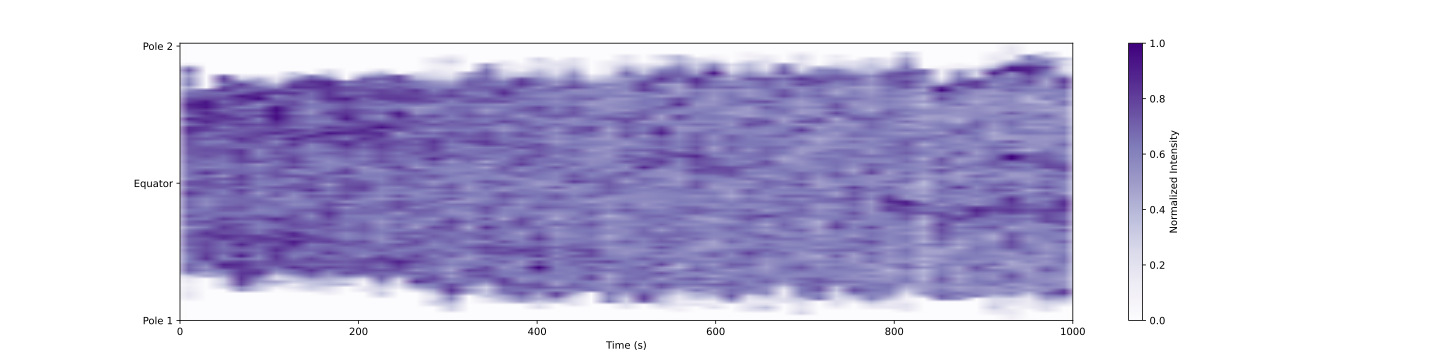

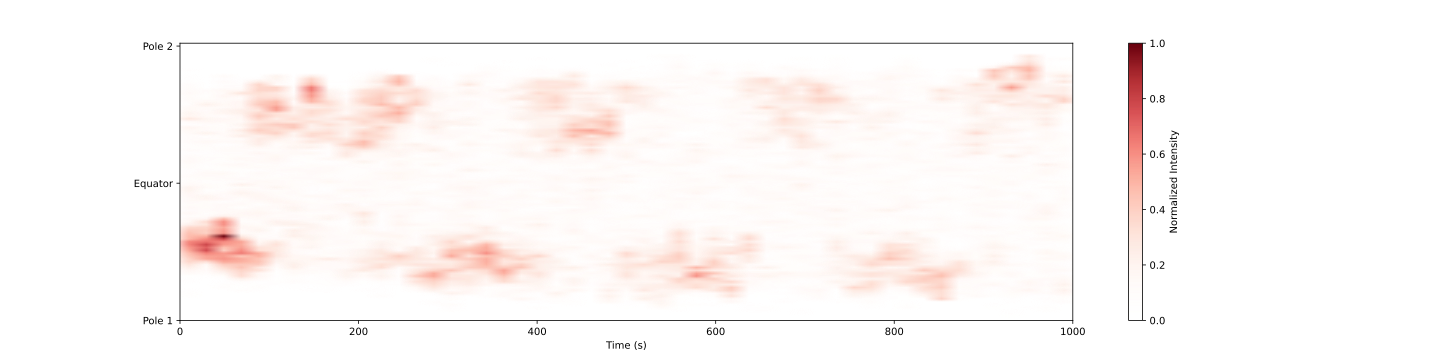

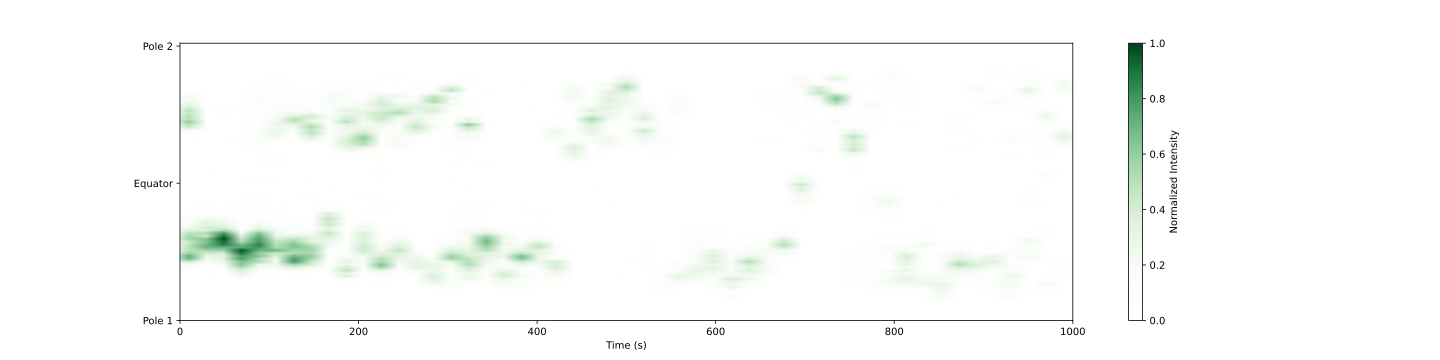

In [11]:
# Display saved SVG files
from IPython.display import SVG, display

display(SVG(save_path_c1))
display(SVG(save_path_c2))  
display(SVG(save_path_c3))